In [23]:
import gymnasium as gym
import os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm
from collections import deque, defaultdict
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 2328.23it/s]
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1119:

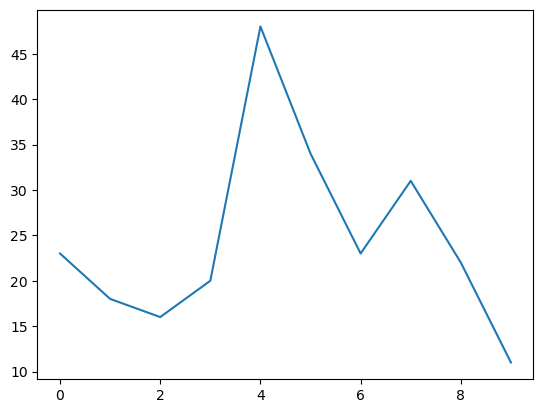

In [3]:
env = gym.make('CartPole-v1')
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# Model

In [22]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size = 128):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size * 2)
        self.linear3 = nn.Linear(hidden_size * 2, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size * 2)
        self.linear3 = nn.Linear(hidden_size * 2, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value


def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output','cartpole')

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

def trainIters(env, actor, critic, n_iters, device, label = 'baseline', plot_update_freq = 50):

    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)


    optimizerA = optim.Adam(actor.parameters())
    optimizerC = optim.Adam(critic.parameters())
    loop = tqdm(range(n_iters))
    reward_window = deque(maxlen=100)
    history = defaultdict(list)

    best_avg_reward = -float('inf')

    for iter in loop:
        state, info = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        # entropy = 0
        done = False
        total_reward = 0

        for i in count():
            state = torch.FloatTensor(state).to(device)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, terminated, truncated, info = env.step(action.cpu().numpy())
            total_reward += reward

            log_prob = dist.log_prob(action).unsqueeze(0)
            # entropy += dist.entropy().mean()

            done =  terminated or truncated

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

            state = next_state

            if done:
                break

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = critic(next_state)
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()

        reward_window.append(total_reward)

        avg_reward = np.mean(reward_window)

        history['reward'].append(avg_reward)

        loop.set_description(f'avg reward = {avg_reward}')

        if best_avg_reward <= avg_reward:
            best_avg_reward = avg_reward
            #save best model
            torch.save(actor, os.path.join(SAVE_PATH, 'actor.torch'))
            torch.save(critic, os.path.join(SAVE_PATH, 'critic.torch'))
        
        if iter % plot_update_freq == 0:
            plot(history, save_path = FIG_SAVE_PATH)

    env.close()
    return history

def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# env = gym.make("CartPole-v1").unwrapped
env = gym.make("CartPole-v1")
# env = gym.make("LunarLander-v2")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001
epochs = 500


actor = Actor(state_size, action_size).to(device)
critic = Critic(state_size, action_size).to(device)
history = trainIters(env, actor, critic, n_iters=epochs, device = device, label = 'test_run')
torch.save(actor, 'actor.torch')
torch.save(critic, 'critic.torch')
plot(history)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
avg reward = 32.0:   0%|          | 0/500 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore

/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

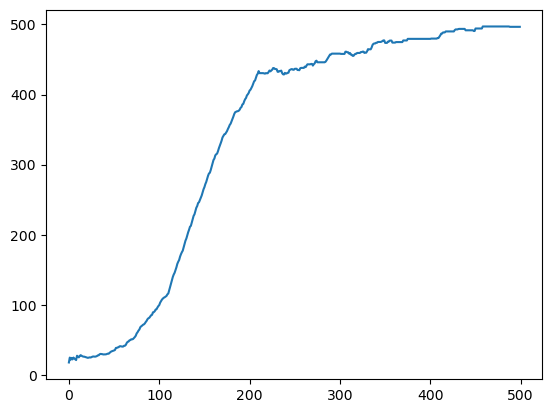

# Run cart pole

  0%|          | 0/100 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
ep = 99, reward = 500.0: 100%|██████████| 100/100 [00:06<00:00, 15.78it/s]
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages

<Axes: >

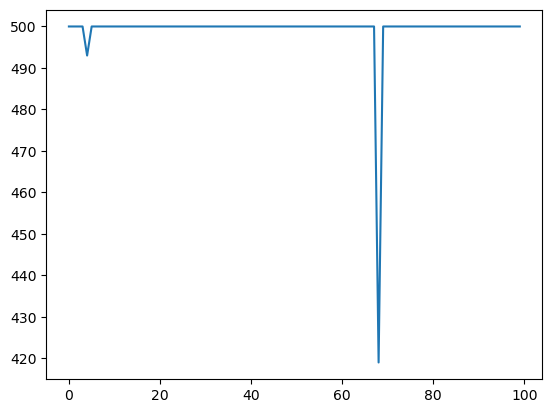

In [21]:
# nv = gym.make('CartPole-v1')
env = gym.make('CartPole-v1')
rewards = []

# net = torch.load('best_target_net.torch')
# net = torch.load(os.path.join(OUTPUT, 'baseline', 'policy_net.checkpoint.torch'))
loop = tqdm(range(100))
total_rewards = []

for epoch in loop:
    state, info = env.reset()
    total_reward = 0

    for step in count():
        state = torch.tensor(state).float()
        action_dist = actor(state)
        action = action_dist.sample()

        next_state, reward, terminated, truncated, info = env.step(action.cpu().numpy())
        state = next_state
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break
    
    total_rewards.append(total_reward)

    loop.set_description(f'ep = {epoch}, reward = {total_reward}')
    rewards.append(total_reward)
    
sns.lineplot(y = total_rewards, x= list(range(len(rewards))))

# Lunar Lander

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# env = gym.make("CartPole-v1").unwrapped
# env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001
epochs = 10000


actor = Actor(state_size, action_size, hidden_size=64).to(device)
critic = Critic(state_size, action_size, hidden_size=64).to(device)
history = trainIters(env, actor, critic, n_iters=epochs, device = device)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
avg reward = -63.126406528853:   9%|▉         | 879/10000 [01:51<1:29:05,  1.71it/s]   